In [1]:
from utils_v0 import *
from fitted_Q_v0 import *

In [2]:
import pickle

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import gymnasium as gym
import sklearn
import numpy as np

from tqdm import tqdm
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

100%|██████████| 500/500 [00:10<00:00, 47.94it/s]


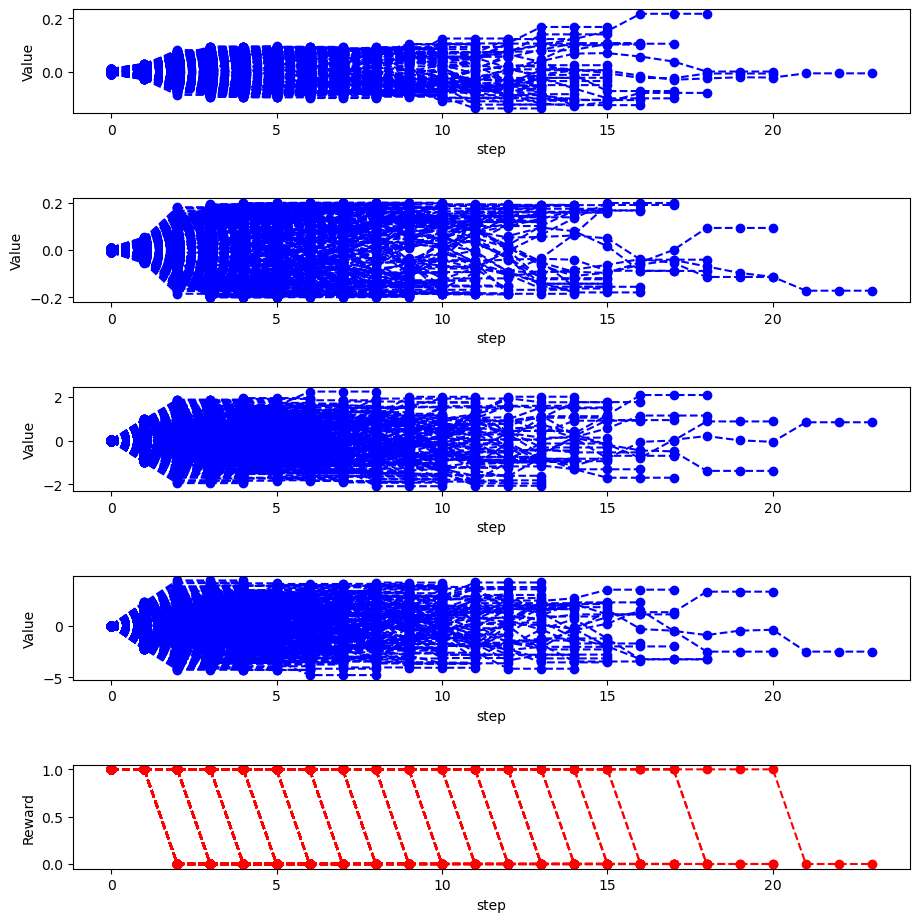

100%|██████████| 100/100 [00:02<00:00, 49.97it/s]


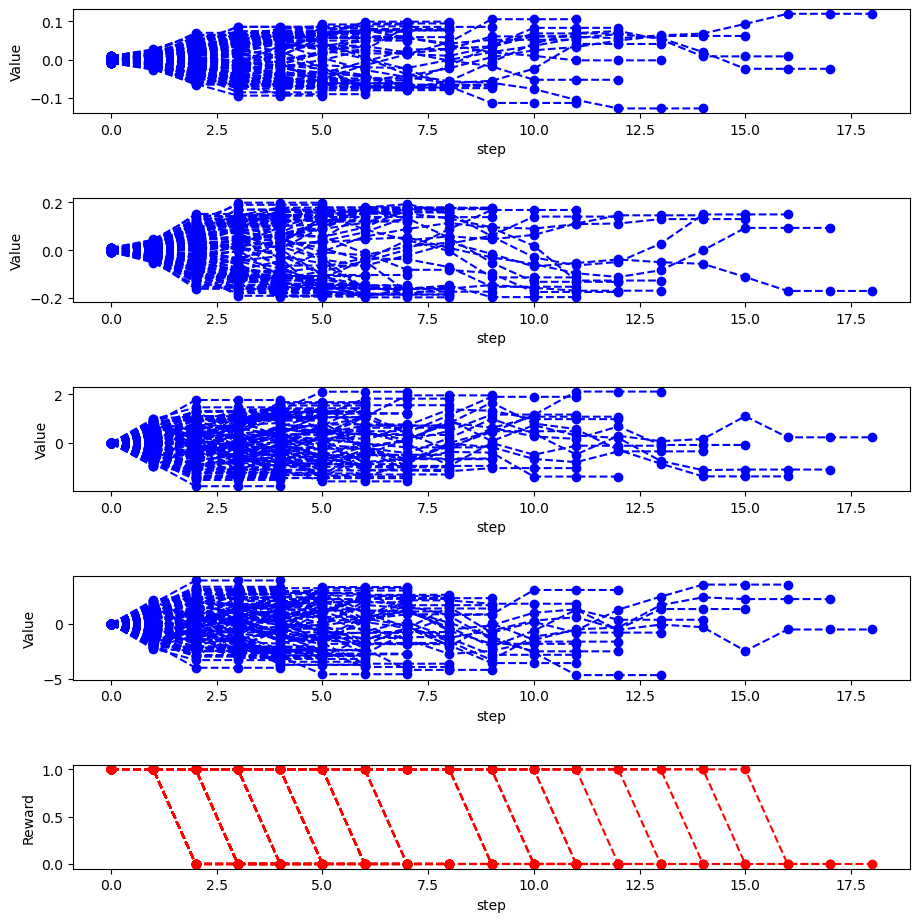

100%|██████████| 4842/4842 [00:00<00:00, 66352.86it/s]


(4842, 5)


100%|██████████| 500/500 [01:49<00:00,  4.58it/s]


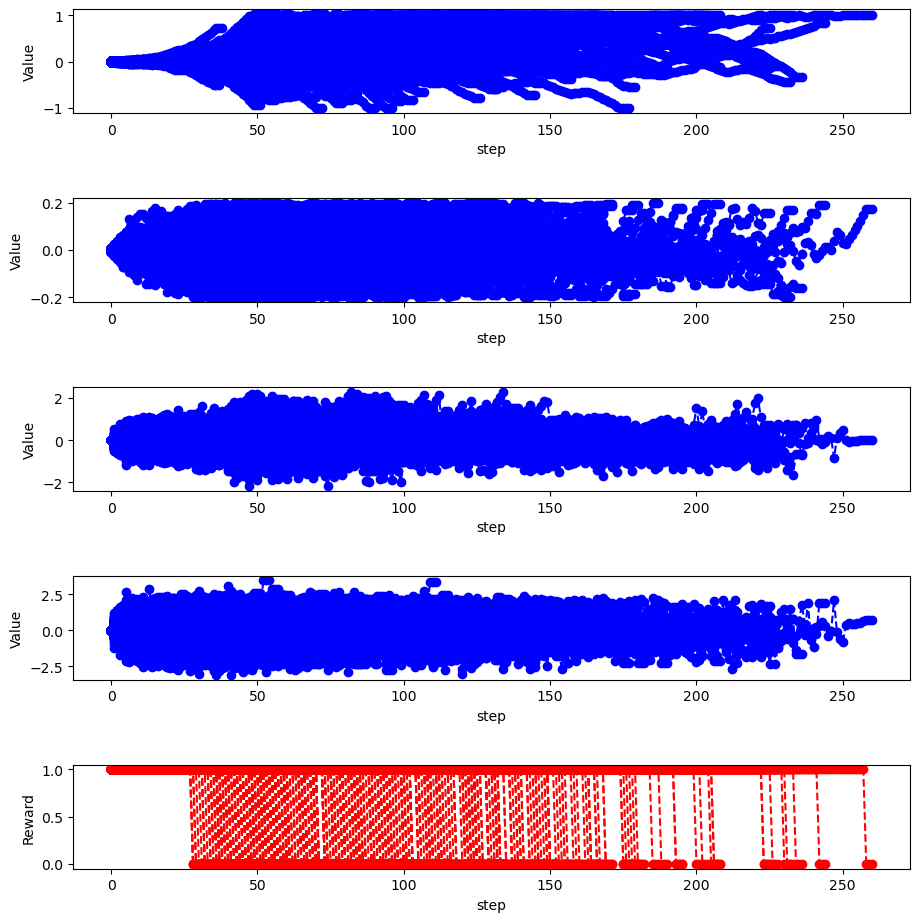

100%|██████████| 100/100 [00:01<00:00, 57.95it/s]


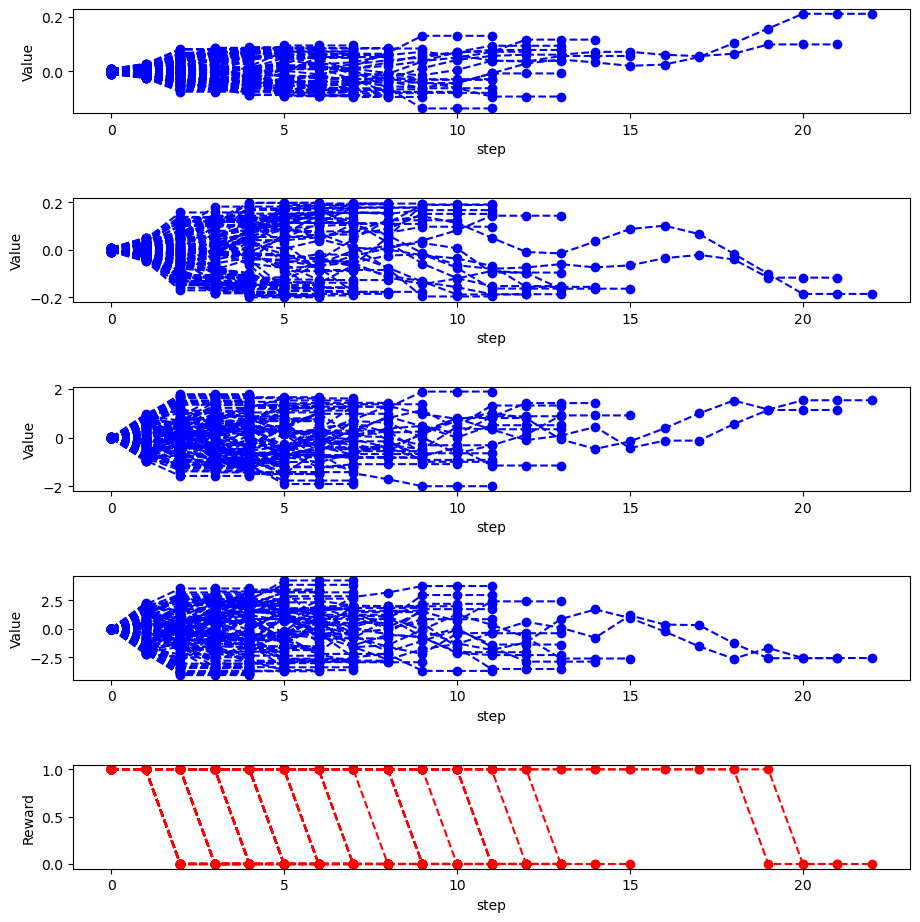

100%|██████████| 50991/50991 [00:03<00:00, 13602.35it/s]


(50991, 5)


100%|██████████| 500/500 [02:04<00:00,  4.02it/s]


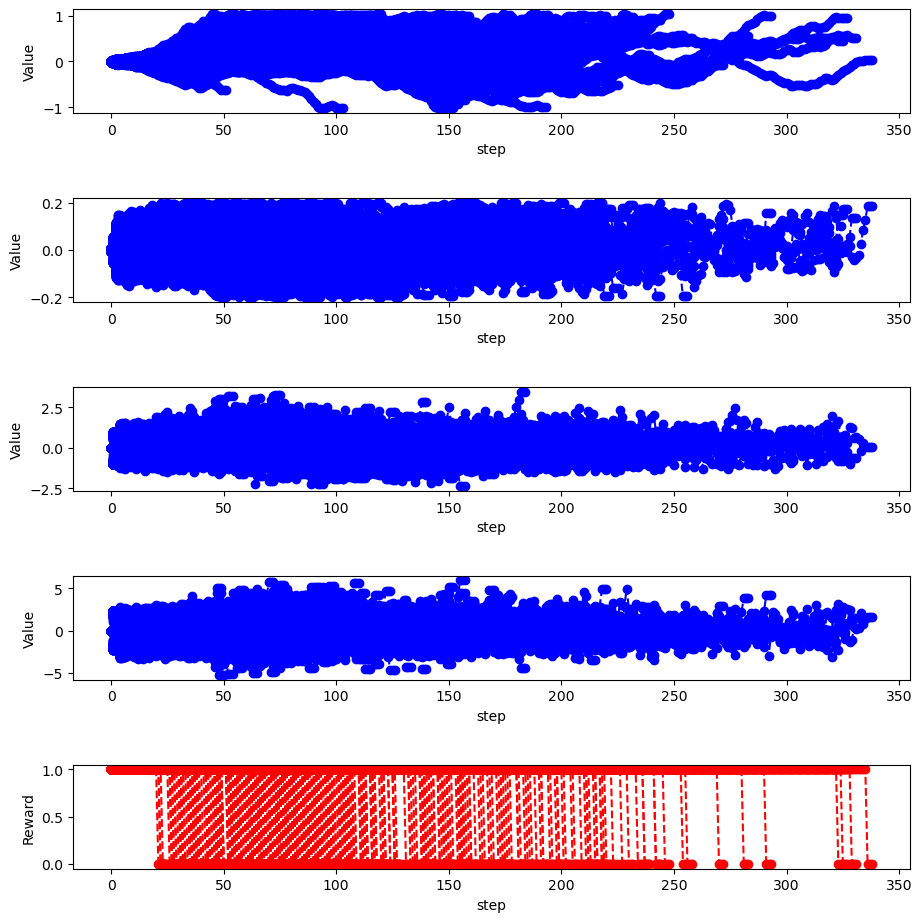

100%|██████████| 100/100 [00:01<00:00, 53.03it/s]


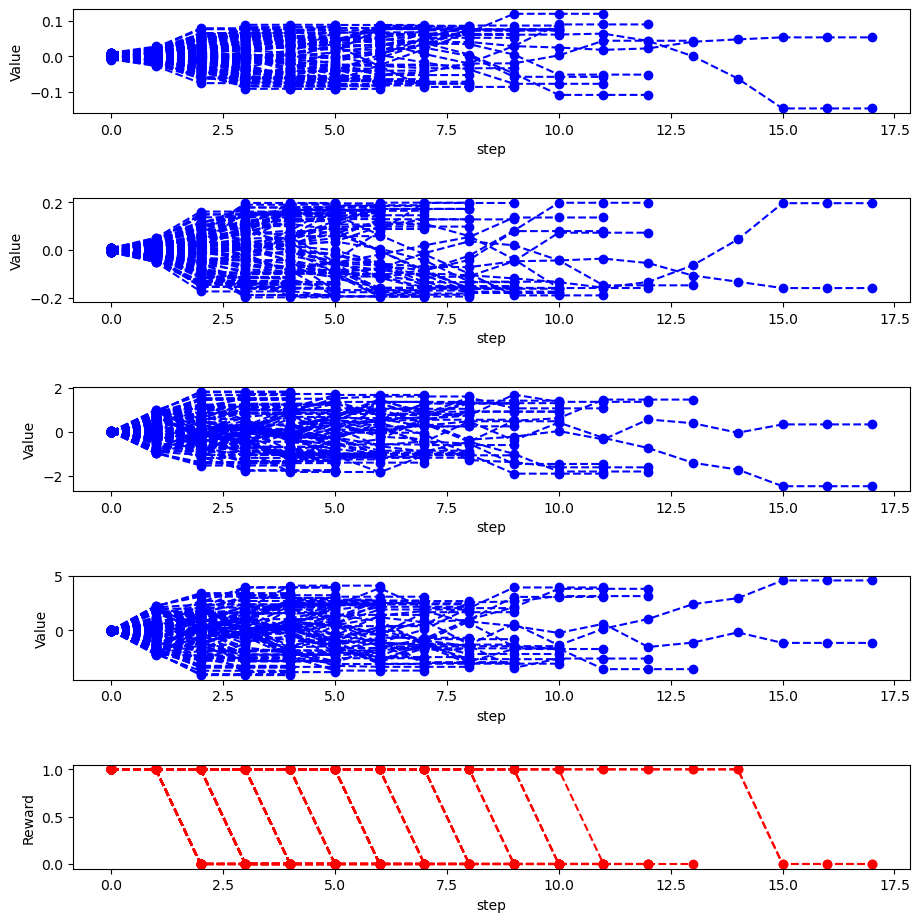

100%|██████████| 102206/102206 [00:13<00:00, 7318.55it/s]


(102206, 5)


100%|██████████| 60/60 [58:40<00:00, 58.68s/it]


In [5]:
nbIt = 180
nbTraj = 500
est = FQI_loop('InvertedPendulum-v4', nbIt= nbIt, nbTraj = nbTraj )

In [8]:
a = [2]
c = np.random.normal()
d = a[0] + c

In [ ]:
saveModell(est, 'test_last.sav')

In [7]:
angleVect = np.linspace(-2, 2, 50)
speedVect = np.linspace(-6, 6, 60)
angleSpeedVect = np.linspace(-0.0004, 0.0004, 70)
actionSet = np.linspace(-3, 3, 80)

pMat, Qmax = getPolicyMat(angleVect, speedVect, angleSpeedVect, actionSet, est)

100%|██████████| 80/80 [00:08<00:00,  9.37it/s]


In [8]:
def contour_2D(matrix, x, y, display = 1):
        
    fig = plt.figure()
    ax = plt.axes()

    X, Y = np.meshgrid(x, y)

    ax.contourf(X, Y, matrix.T)

    #fig.colorbar()

    #ax.pcolormesh(x, y, matrix.T, cmap='RdBu')

    if display:
        plt.show()

    return fig, ax

In [9]:
def plot_inter_2D(matrix, x, y, display = 1):
        
    fig = plt.figure()
    ax = plt.axes()

    ax.pcolormesh(x, y, matrix.T, cmap='RdBu')

    if display:
        plt.show()

    return fig, ax

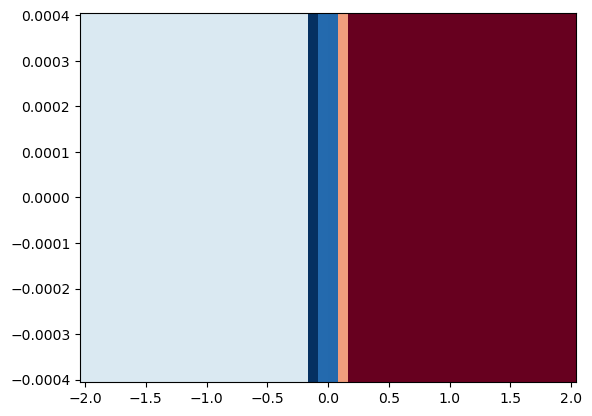

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [11]:
plot_inter_2D(Qmax[:, 0, :], angleVect, angleSpeedVect, display = 1)

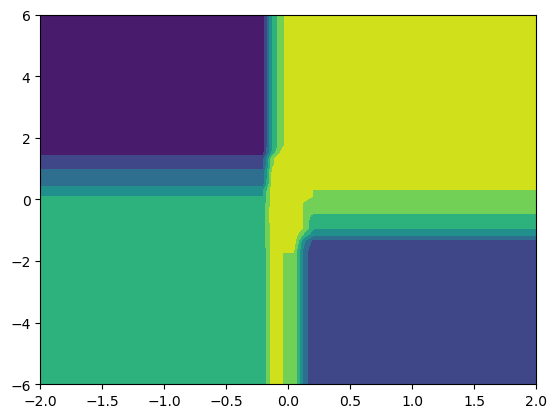

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [12]:
contour_2D(Qmax[:, :, 0], angleVect, speedVect, display = 1)

In [5]:
actionSet = np.linspace(-3, 3, 200)
agEst = estAgent(est, actionSet)

In [6]:
def estExpResults(envName, ag, gamma, nb = 50):
    """
    Compute the expected return of a policy embodied in the agent

    Args:
    -----
    - `envName`: name of the environment
    - `ag`: agent
    - `gamma`: gamma of the model
    - `nb`: number of times the experience is repeated

    Output:
    -------
    the expected cummulative return and the corresponding standard deviation
    """

    rewardList = []

    print("Estimating expected result")
    for _ in tqdm(range(nb)):
        env = gym.make(envName)
        obs = env.reset()
        obs = obs[0]          

        terminatedBool = 0
        reward_c = 0
        t = 0
        while terminatedBool == 0:
            act = ag.choose_action(obs[1:])
            nextObs, reward, done, info, _ = env.step([act])

            if done:
                reward = 0
                terminatedBool = 1


            reward_c += (gamma**t) * reward
            obs = nextObs
            t+=1

        rewardList.append(reward_c)

    return np.mean(rewardList), np.std(rewardList)

In [27]:
class estAgent():
    """
    Agent that uses a trained estimator in order to decide which action should be taken
    """

    def __init__(self, est, actionSet, pytorchBool = 0):
        self.obs = None
        self.cumReward = 0  
        self.est = est  
        self.actionSet = actionSet
        self.pytorchBool = pytorchBool

    def choose_action(self, state):

        L = len(self.actionSet)
        S = len(state)
        Tlength = S+1

        if self.pytorchBool:
            self.est.eval()     #verif ecriture

        possTuples = np.zeros((L, Tlength))

        for i in range(L):
            possTuples[i] = [*state, self.actionSet[i]]

        if self.pytorchBool:
            res = self.est(possTuples)
        else:
            res = self.est.predict(possTuples)

        ind = np.argmax(res)
        
        return self.actionSet[ind]
    

In [30]:
estExpResults('InvertedPendulum-v4', agEst, gamma = 0.95)

Estimating expected result


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


(19.31098040282046, 0.7023444832201816)

In [7]:
def simulate(envName, agent,  nb = 200):                                # predefined args
    """
    Allows to simulate a trajectory of size nb

    Args:
    -----
    - `envName`: name of the gym environment
    - `agent`: agent used to generate trajectory (see agents.py)
    - `nb`: length of the trajectory

    Output:
    -------
    - a list with the different steps
    A step = ((observables), action, reward, (next_observables))
    """

    #env = gym.make(envName, render_mode = "human")
    env = gym.make(envName)                                     # creating gym environment
    obs = env.reset()                                           # reset the environment for the start
    obs = obs[0]                                                # first observables
    traj = []                                                   # initialization of the list

    for _ in range(nb):
        act = agent.choose_action(obs)
        nextObs, reward, done, info, _ = env.step(act)          # step in the environment

        ## force the reward to 0 when a terminal state is reached
        if done:
            reward = 0
            traj.append((obs, act[0], reward, nextObs))
            traj.append((obs, act[0], reward, nextObs))
            traj.append((obs, act[0], reward, nextObs))
            return traj

        
        traj.append((obs, act[0], reward, nextObs))
        obs = nextObs

    return traj

In [111]:
class randAgent():
    """
    Agent that chooses with a uniform random in [-3, 3] the action to follow
    """
    def __init__(self):
        self.obs = None
        self.cumReward = 0

    def choose_action(self, state):
        return [np.random.uniform(-3, 3)]

In [112]:
def plotTraj(traj, fig=None, axes=None, display=1):

    if (fig is None) or (axes is None):
        fig, axes = plt.subplots(5, figsize=(10, 10))
        fig.tight_layout(pad=4.0)

    inds = np.arange(len(traj))
    for j in range(len(traj[0][0])):

        elems = np.array([traj[i][0][j] for i in range(len(traj))])
        axes[j].scatter(inds, elems, marker='o', color='blue')
        axes[j].plot(inds, elems, 'b--')

        axes[j].grid()

        axes[j].set_xlabel("step")
        axes[j].set_ylabel("Value")  
        #if j == 0:
        #    print(f'{j} ==> [{min(elems)}, {max(elems)}]')

    elems = np.array([traj[i][2] for i in range(len(traj))]) 
    axes[4].scatter(inds, elems, marker='o', color='red')
    axes[4].plot(inds, elems, 'r--')   
    axes[4].grid()

    axes[4].set_xlabel("step")
    axes[4].set_ylabel("Reward") 

    if display:
        plt.show()

    return fig, axes

100%|██████████| 1000/1000 [00:35<00:00, 28.03it/s]


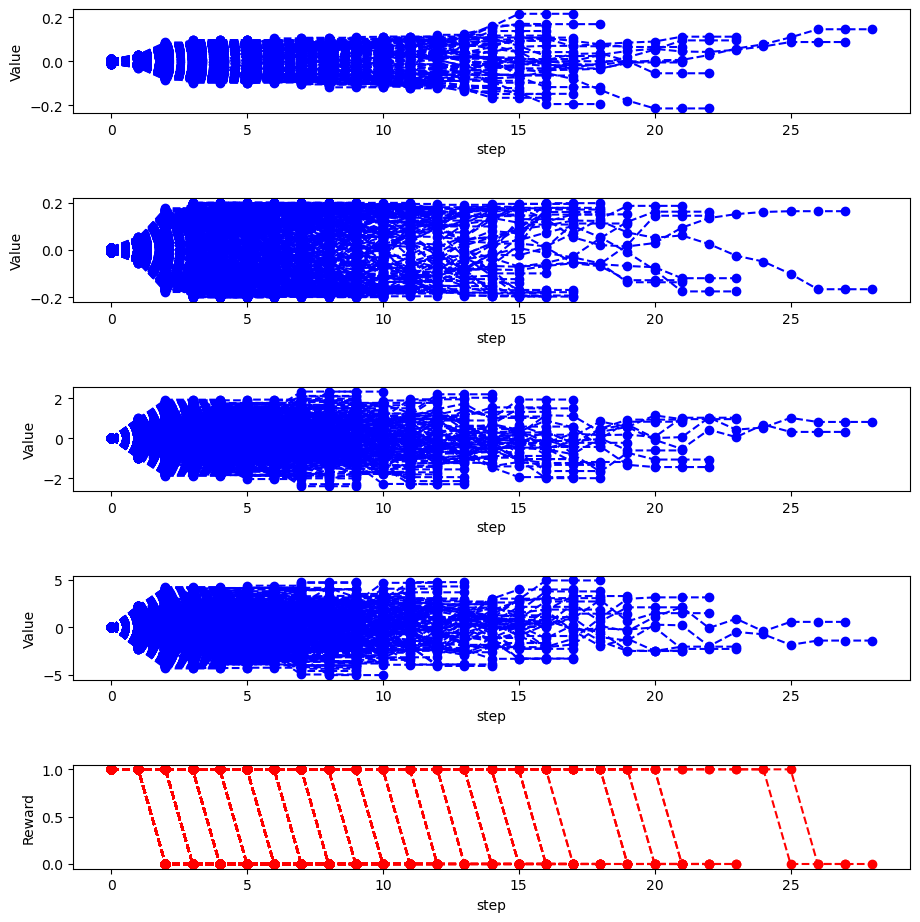

In [2]:
ag1 = randAgent()
for c in tqdm(range(1000)):
    traj = simulate('InvertedPendulum-v4', ag1, 80)
    if c == 0:
        fig, axes = plotTraj(traj, display = 0)
    else:
        fig, axes = plotTraj(traj, fig, axes, display = 0)

plt.show()

In [120]:
print(traj[-1])

(array([ 0.10563384, -0.18564442,  0.78704048, -1.45875318]), 1.2248768198707136, 0, array([ 0.14527097, -0.26429844,  1.19307807, -2.46850307]))


In [29]:
def show_agent(envName, ag):
    env = gym.make(envName,render_mode = "human")
    
    obs = env.reset()                                           # reset the environment for the start
    obs = obs[0]                                                # first observables
    endBool = False

    while not endBool:
        action = ag.choose_action(obs)
        obs, reward, endBool, info,e = env.step(action)
        print(obs, endBool, info)
        obs = obs

        env.render()
    return env

In [25]:
actionSetDisc = np.linspace(-3, 3, 300)
ag_test = estAgent(est,actionSetDisc)
#ag_test = randAgent()
#env = show_agent('InvertedPendulum-v4', ag_test)
r = []
for _ in tqdm(range(1000)):
    r.append(len(simulate('InvertedPendulum-v4', ag_test, 100000)))
print(np.mean(r))
print(np.std(r))

100%|██████████| 1000/1000 [05:33<00:00,  2.99it/s]

202.932
152.9642617607132


In [60]:
env.close()

In [76]:
gammaVect = np.array([0.95**t for t in range(10)])
print(gammaVect)

indsGamma = np.arange(10-2)
gam = gammaVect[indsGamma]
print(gam)

[1.         0.95       0.9025     0.857375   0.81450625 0.77378094
 0.73509189 0.6983373  0.66342043 0.63024941]
[1.         0.95       0.9025     0.857375   0.81450625 0.77378094
 0.73509189 0.6983373 ]


In [2]:
pickle.dump(est, open('model_0.sav', 'rb'))

NameError: name 'est' is not defined